In [1]:
# import libraries
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset

import matplotlib.pyplot as plt

import tqdm

from typing import Sequence, Tuple, Optional, List

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

# Import and Process the Data

In [4]:
### MNIST data

# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels, normalize, reshape
labelsT   = torch.tensor( data[:,0] ).long()
data      = data[:,1:]
dataNorm  = data / np.max(data)
dataNormT = torch.tensor( dataNorm.reshape(dataNorm.shape[0],1,28,28) ).float()

# split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataNormT, labelsT, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 32
numbers_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
numbers_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [5]:
### FMNIST data

# transformations
transform = T.Compose([ T.ToTensor(), T.Normalize(.5,.5) ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize    = 32
fashion_train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
fashion_test_loader  = DataLoader(testset, batch_size=len(testset))

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.81MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 57.6MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.58MB/s]


In [14]:
X, y = next(iter(fashion_train_loader))
print(X.shape)
print(y.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [13]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Create DL model

In [6]:
# Helper functions

def _as_list(value, n: int):
    """Normalize a scalar/tuple/sequence into a list of length n.
       - If value is a scalar or tuple, replicate it n times.
       - If value is a sequence of length 1, replicate it n times.
       - If value is a sequence of length n, use as is.
    """

    # tuples are valid for kernel/stride/padding/dilation
    if isinstance(value, (int, float, tuple)):
        return [value for _ in range(n)]
    if isinstance(value, Sequence):
        if len(value) == 1 and n > 1:
            return [value[0] for _ in range(n)]
        if len(value) == n:
            return list(value)
    raise ValueError(f"Could not broadcast parameter to length {n}: {value}")

In [16]:
# create a class for the model

def makeTheNet(out_channels: Sequence[int] = [6,6],         #conv1, conv2
                kernel_size: int | Tuple[int, int]=3,
                stride: int | Tuple[int, int]=1,
                padding: Optional[int | Tuple[int, int]]=[1,0],
                pool_size: Optional[Tuple[int, int]]=(2,2),
                dilation: int | Tuple[int, int]=1,
                groups: int =1,
                bias: bool =True,
                padding_mode: str='zeros',
                cv_dropout: float = 0.0,
                cv_batchnorm: bool = False,

                # Defintions for the FC layer
                uLinear: Optional[Sequence[int]] = [50],
                ln_batchnorm: bool = False,
                out_size: int = 26,
                ln_dropout: float = 0.0,

                # Regularization
                optimizer = 'Adam',
                weight_decay: float = 0.0,
                lr: float = 1e-3,

                #Loss Function
                lossfunc = nn.CrossEntropyLoss(),

                device=None,
                dtype=None,
                printtoggle: bool = False):

  class cnnNet(nn.Module):
    def __init__(self,
                out_channels: Sequence[int] = out_channels,     #conv1, conv2
                kernel_size: int | Tuple[int, int]=kernel_size,
                stride: int | Tuple[int, int]=stride,
                padding: Optional[int | Tuple[int, int]]=padding,
                pool_size: Optional[Tuple[int, int]]=pool_size,
                dilation: int | Tuple[int, int]=dilation,
                groups: int =groups,
                bias: bool = bias,
                padding_mode: str=padding_mode,
                cv_dropout: float = cv_dropout,
                cv_batchnorm: bool = cv_batchnorm,

                # Defintions for the FC layer
                uLinear: Optional[Sequence[int]] = uLinear,
                ln_batchnorm: bool = ln_batchnorm,
                out_size: int = out_size,
                ln_dropout: float = ln_dropout,
                device=device,
                dtype=dtype,
                printtoggle: bool = printtoggle
                ):
      super().__init__()

      for i, oc in enumerate(out_channels):
          assert int(oc) > 0, f"out_channels[{i}] must be > 0, got {oc}"


      # print toggle
      self.printtoggle = printtoggle

      self.pool = nn.MaxPool2d(pool_size)

      self.cv_batchnorm = cv_batchnorm
      self.ln_batchnorm = ln_batchnorm


      nBlocks = len(out_channels)               # number of conv blocks

      # Normalize per-block parameters
      k_list = _as_list(kernel_size, nBlocks)
      s_list = _as_list(stride,      nBlocks)
      p_list = _as_list(padding,     nBlocks)
      d_list = _as_list(dilation,    nBlocks)
      pool_list = _as_list(pool_size, nBlocks)

      #--------Build Convoluation Blocks----------
      convs = []
      cbns = []                 # Batch normalization for each layer
      pools = []
      cdo = []                 # Dropout per convolution block (optional)


      # ---- Convolutional stack ----
      for i in range(nBlocks):
        convs.append(nn.LazyConv2d(
        out_channels=out_channels[i],
        kernel_size=k_list[i],
        stride=s_list[i],
        padding=p_list[i],
        dilation=d_list[i],
        groups=groups,
        bias=bias,
        padding_mode=padding_mode
    ))

        if self.cv_batchnorm:
          cbns.append(nn.BatchNorm2d(out_channels[i]))
        else:
          cbns.append(nn.Identity())

        pools.append(nn.MaxPool2d(kernel_size=pool_list[i]))

        if cv_dropout > 0:
          cdo.append(nn.Dropout2d(cv_dropout))
        else:
          cdo.append(nn.Identity())

      self.convs = nn.ModuleList(convs)
      self.cbns  = nn.ModuleList(cbns)
      self.pools = nn.ModuleList(pools)
      self.cdo   = nn.ModuleList(cdo)

      # Safety checks (helps catch the “zip returns nothing” bug)
      assert len(self.convs) > 0, "No conv blocks built"
      assert len(self.convs) == len(self.pools) == len(self.cbns) == len(self.cdo), (len(self.convs), len(self.pools), len(self.cbns), len(self.cdo))

      # --- Linear stack/ Multi-Layer Perceptorn (MLP) (variable depth) ---
      sizes = list(uLinear) if uLinear is not None else [50]
      fcs, fbns, fdo = [], [], []

      for h in sizes:
          fcs.append(nn.LazyLinear(h))
          if self.ln_batchnorm:
            fbns.append(nn.BatchNorm1d(h))
          else:
            fbns.append(nn.Identity())

          if ln_dropout > 0:
              fdo.append(nn.Dropout(ln_dropout))
          else:
              fdo.append(nn.Identity())


      self.fcs  = nn.ModuleList(fcs)
      self.fbns = nn.ModuleList(fbns)
      self.fdo  = nn.ModuleList(fdo)
      self.output_layer = nn.LazyLinear(out_size)

    def forward(self,x):

      if self.printtoggle: print(f'Input: {list(x.shape)}')

      # Convolutional stack: Conv -> (BN) -> Max_Pool -> LeakyReLU -> (Dropout2d)
      for i in range(len(self.convs)):

        x = self.convs[i](x)
        x = self.cbns[i](x)
        x = self.pools[i](x)
        x = F.leaky_relu(x, inplace=True)
        x = self.cdo[i](x)

        if self.printtoggle: print(f'After block {i+1}: {list(x.shape)}')
        if self.printtoggle: print(f'Block {i+1} padding {self.convs[i].padding}')

      # reshape for linear layer
      x = torch.flatten(x,start_dim=1)
      if self.printtoggle: print(f'Vectorized: {list(x.shape)}')

      ## FC stack
      for i in range(len(self.fcs)):

        x = self.fcs[i](x)
        x = self.fbns[i](x)
        x = F.leaky_relu(x, inplace=True)
        x = self.fdo[i](x)

        if self.printtoggle: print(f'After FC {i+1}: {list(x.shape)}')


      x = self.output_layer(x)

      return x

  #-------------------End of model factory------------------------------

  # create the model instance
  net = cnnNet()

  # Move to device/dtype once (constructor kwargs are version-fragile)
  if device is not None or dtype is not None:
      net = net.to(device=device, dtype=dtype)

  # loss function
  lossfun = lossfunc

  # optimizer
  optimizer = getattr(torch.optim,optimizer)(net.parameters(),lr=lr,weight_decay=weight_decay)

  return net,lossfun,optimizer

In [27]:
# test the model with one batch
out_channels = [10,20]
uLinear = [50]
paddings = [1,1]
out_size = 10
printtoggle = True
lossfunc = nn.CrossEntropyLoss()

net,lossfun,optimizer = makeTheNet(out_size = out_size,
                                   out_channels = out_channels,
                                   uLinear = uLinear,
                                   padding = paddings,
                                   lossfunc = lossfunc,
                                   printtoggle=printtoggle
                                )

X,y = next(iter(fashion_train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y).detach().numpy()
print(' ')
print('Loss:', loss)

# Calculate Accuracy
matches = torch.argmax(yHat,axis=1) == y
accuracy = 100 * matches.float().mean()
print(' ')
print('Accuracy:',accuracy)

Input: [32, 1, 28, 28]
After block 1: [32, 10, 14, 14]
Block 1 padding (1, 1)
After block 2: [32, 20, 7, 7]
Block 2 padding (1, 1)
Vectorized: [32, 980]
After FC 1: [32, 50]

Output size:
torch.Size([32, 10])
 
Loss:
2.3087661
 
Accuracy: tensor(3.1250)


# Create a function to train the model

In [28]:
# a function that trains the model

# input the network and the number of epochs to train
def function2trainTheModel(net,train_loader,test_loader,numepochs=10):

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compute test accuracy
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Train the model and show the results

In [29]:
# create a new model
out_channels = [10,20]
uLinear = [50]
paddings = [1,1]
out_size = 10
printtoggle = False
lossfunc = nn.CrossEntropyLoss()

numberNet,lossfun,optimizer = makeTheNet(out_size = out_size,
                                   out_channels = out_channels,
                                   uLinear = uLinear,
                                   padding = paddings,
                                   lossfunc = lossfunc,
                                   printtoggle=printtoggle
                                )

numepochs = 5
# train it on numbers data
trainAcc,testAcc,losses,numberNet = function2trainTheModel(numberNet,numbers_train_loader,numbers_test_loader,numepochs)

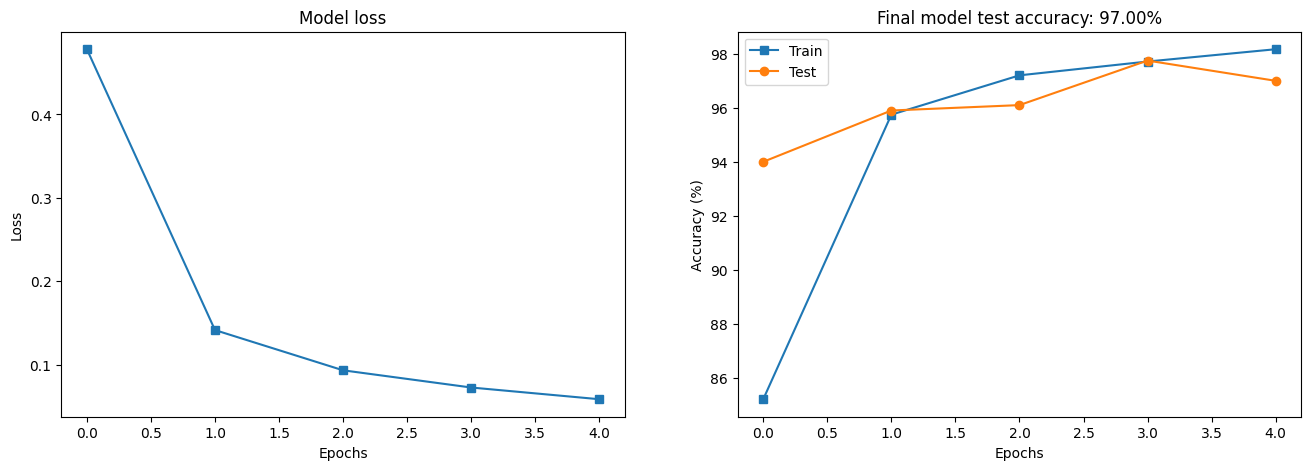

In [30]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show();

# Test the trained model on fashion data

In [31]:
# test the model with fashion data

# extract X,y from FASHION test dataloader
X,y = next(iter(fashion_test_loader))
yHat = numberNet(X)

# the test
fashionAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

print(f'NUMBERNET performance on FASHION data: {fashionAcc:.2f}%')

NUMBERNET performance on FASHION data: 17.83%


# Fine tune the model for Fashin EMNIST

In [74]:
fashion_train_loader.dataset.data.shape

torch.Size([60000, 28, 28])

In [75]:
# Create the target model
# create a new model
out_channels = [10,20]
uLinear = [50]
paddings = [1,1]
out_size = 10
printtoggle = False
lossfunc = nn.CrossEntropyLoss()

fashionNet,lossfun,optimizer = makeTheNet(out_size = out_size,
                                   out_channels = out_channels,
                                   uLinear = uLinear,
                                   padding = paddings,
                                   lossfunc = lossfunc,
                                   printtoggle=printtoggle
                                )

# Dummy run since Lazy modules have been used
image_dimH = fashion_train_loader.dataset.data.shape[1]
image_dimW = fashion_train_loader.dataset.data.shape[2]

with torch.no_grad():
  fashionNet(torch.zeros(1,1,image_dimH,image_dimW))

print( fashionNet.convs[0].weight[0] - numberNet.convs[0].weight[0] )

tensor([[[-0.0064, -0.3174, -0.3114],
         [ 0.2162,  0.2899,  0.5393],
         [-0.0827,  0.1204,  0.2210]]], grad_fn=<SubBackward0>)


In [76]:
import copy
# Replace all the weights in TARGET model from SOURCE model
for target,source in zip(fashionNet.named_parameters(),numberNet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

print( fashionNet.convs[0].weight[0] - numberNet.convs[0].weight[0] )

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], grad_fn=<SubBackward0>)


# Evaluate the target model

In [77]:
trainAcc,testAcc,losses,fashionNet = function2trainTheModel(
                                         fashionNet,fashion_train_loader,fashion_test_loader,1)

In [78]:
print(f'numberNet TRAIN accuracy: {trainAcc[-1]:.2f}%')
print(f'numberNet TEST accuracy: {testAcc[-1]:.2f}%')

numberNet TRAIN accuracy: 81.56%
numberNet TEST accuracy: 86.66%
